# Hands-on 7: QAOA


In this notebook we look at how pyAQASM can be used to efficiently simulate QAOA.

- Step 1: Parametrized circuit
- Step 2: Observables
- Step 3: CombinatorialProblem class
- Step 4: MaxCut with QAOA


## Step 1: Parametrized circuit

Parametrized circuits are an important piece to solve variational algorithms with pyAQASM.
The goal of this first step is simply to show you how to create and instance them manually.
So you have understanding of the tools used by the functions available to solve variational algorithms.

Moreover you could definitely create your own parametrized circuit and use optimization plugins on it.

To do this Step 1 we will use the example of the Hands-on 2:

Create a parametrized circuit with:
+ a single qubit
+ a single RY gate with a variable

<img src="RY-theta.PNG">

In [1]:
from qat.lang.AQASM import *
prog = Program()
qubits_reg = prog.qalloc(1)

#Define your variables
theta = prog.new_var(float, "\\theta")

#Apply a gate with a rotation along the Y-axis with a parameter
prog.apply(RY(theta), qubits_reg[0])

#Create and display the circuit
circuit = prog.to_circ()
%qatdisplay --svg circuit

Once the parametrized goal is to create a superposition of:
+ 30% to get the state 0
+ 70% to get the state 1

Reminder: An angle of 1.9823 will do the job.

In [2]:
new_circuit = circuit.bind_variables({"\\theta": 1.9823})
%qatdisplay --svg new_circuit

You can now execute your binded circuit to verify the result.

In [3]:
#Create a Job from the circuit generated by binding the variable
job = new_circuit.to_job()

#Import and create the linear algebra simulator
from qat.qpus import PyLinalg
linalgqpu = PyLinalg()

#Submit the job to the simulator PyLinalg and get the results
result = linalgqpu.submit(job)

#Print the results
for sample in result:
    print("State %s probability %s" % (sample.state, sample.probability))

State |0> probability 0.30000603658125197
State |1> probability 0.699993963418748


Let's continue with:
+ two qubits
+ two gates

<img src="2RY.PNG">


In [4]:
from qat.lang.AQASM import *
prog = Program()
qubits_reg = prog.qalloc(2)

#Define your variables
theta = prog.new_var(float, "\\theta")
gamma = prog.new_var(float, "\\gamma")

#Apply the two gates with two variables
prog.apply(RY(theta), qubits_reg[0])
prog.apply(RY(gamma), qubits_reg[1])

#Create and display the circuit
circuit = prog.to_circ()
%qatdisplay --svg circuit

the result we want is:
+ 24% for |00>
+ 56% for |01>
+ 6%  for |10>
+ 14% for |11>

Reminder: 0.927295 and 1.9823 angles will do it.

In [5]:
new_circuit = circuit.bind_variables({"\\theta": 0.927295, "\\gamma": 1.9823})
%qatdisplay --svg new_circuit

You can now execute your binded circuit to verify the result.

In [6]:
#Create a Job from the circuit generated by binding the variable
job = new_circuit.to_job()

#Import and create the linear algebra simulator
from qat.qpus import PyLinalg
linalgqpu = PyLinalg()

#Submit the job to the simulator PyLinalg and get the results
result = linalgqpu.submit(job)

#Print the results
for sample in result:
    print("State %s probability %s" % (sample.state, sample.probability))

State |00> probability 0.24000485542571934
State |01> probability 0.5599952317749185
State |10> probability 0.060001181155532664
State |11> probability 0.13999873164382956


## Step 2: Observables

Observables are the second important tool used by the QLM to solve efficiently the variational algorithms.

We will take as example a simple observable that counts the number of ones in a quantum state over 5 qubits.

This observable can be written as:

$$ O = \Sigma_i (1 - \sigma_z^i)/2 $$

An observable is initialized with the number of qubits it acts on:

In [7]:
from qat.core import Observable, Term
nbqbits = 5
one_count = Observable(nbqbits)

New Pauli terms can be added to the observable.

First, we need to write our observable $O$ as a sum of weighted Pauli operators:

$$ O = N/2 - \Sigma_i \frac{1}{2}\sigma_z^i $$



In [8]:
# The sigma Z terms:
for i in range(nbqbits):
    one_count.add_term(Term(-0.5, "Z", [i]))
# And the constant term:
one_count.constant_coeff += nbqbits/2

We can print our observable to check if it is correct

In [9]:
print(one_count)

2.5 * I^5 +
-0.5 * (Z|[0]) +
-0.5 * (Z|[1]) +
-0.5 * (Z|[2]) +
-0.5 * (Z|[3]) +
-0.5 * (Z|[4])


Lets build a simple circuit and approximate the expectation of our observable over its final state.
<table>
    <tr><td>
        <img src="simple.PNG" width="100%"></td>
    </tr>
</table>

In [10]:
from qat.lang.AQASM import Program, X, CNOT, RX

prog_2_ones = Program()
qbits = prog_2_ones.qalloc(nbqbits)
prog_2_ones.apply(X, qbits[0])
prog_2_ones.apply(CNOT, qbits[0], qbits[2])
circ_2_ones = prog_2_ones.to_circ()

%qatdisplay --svg circ_2_ones

Once the circuit created, we can create a job with our observable "one_count" and submit it to the following stack composed of ObservableSplitter and PyLinalg:

In [26]:
from qat.qpus import PyLinalg
from qat.plugins import ObservableSplitter
qpu = ObservableSplitter() | PyLinalg()

job = circ_2_ones.to_job("OBS", observable=one_count, nbshots=30)
print("Number of ones:", qpu.submit(job).value)

Number of ones: 2.0


Note: I am sur you will ask yourself why adding ObservableSplitter and the answer is because PyLinalg does not natively supports observable sampling, we will use an intermediate plugin ObservableSplitter in order to split the observable carrying job into a collection of basic sampling jobs

We can do the same thing with a less obvious circuit:
<img src="5RX.PNG">

In [27]:
prog = Program()
qbits = prog.qalloc(5)
for i, qb in enumerate(qbits):
    prog.apply(RX(0.324 * i), qb)
circ = prog.to_circ()

%qatdisplay --svg circ

Once the circuit created, we can create a job with our observable "one_count" and submit it with nbshots=30:

In [28]:
job = circ.to_job("OBS", observable=one_count, nbshots=30)
print("Number of ones:", qpu.submit(job).value)

Number of ones: 0.6333333333333333


To decrease the deviation we can increase the number of shots to a thousand for example:

In [29]:
job = circ.to_job(observable=one_count, nbshots=1000)
print("Number of ones:", qpu.submit(job).value)

Number of ones: 0.7069999999999999


Or, we can do the simulation with an "infinite" number of shoots since we are doing simulation using nbshots=0 for example:

In [30]:
job = circ.to_job(observable=one_count)
print("Exact number of ones:", qpu.submit(job).value)

Exact number of ones: 0.7098691594779746


## Step 3: CombinatorialProblem class

The interface of the library is concentrated into a single class `CombinatorialProblem`.

This class allows to:
* declare boolean variables
* add new clauses (i.e boolean formulae) to the final cost function

The goal of this third step is to show you the features of the CombinatorialProblem class.

You first need to import the class CombinatorialProblem from qat.opt when you want to use it:

In [42]:
from qat.opt import CombinatorialProblem

Final energy: -4.751833221875008
Maximization:
 -3.0 * I^5 +
0.5 * (ZZ|[0, 1]) +
0.5 * (ZZ|[0, 4]) +
0.5 * (ZZ|[1, 2]) +
0.5 * (ZZ|[1, 4]) +
0.5 * (ZZ|[2, 3]) +
0.5 * (ZZ|[3, 4])


With the import of CombinatorialProblem done you can create your problem object using the CombinatorialProblem function:

In [62]:
# Declaring a fresh problem
my_problem = CombinatorialProblem()

From your problem object you can now create variables:
+ by giving them names
+ and using the function new_var

In [63]:
# Declaring a new variable
v0 = my_problem.new_var()
v1 = my_problem.new_var()

Or create multiple variables at the same time using new_vars:

In [64]:
# Or several variables
v_array = my_problem.new_vars(4)

Using the following cell you can see that the variables (contained by v0, v1 and v_array) are indexed starting from 0:

In [65]:
# Variable are indexed starting from 0
print(v0, v1)
print(", ".join(str(v) for v in v_array))

V(0) V(1)
V(2), V(3), V(4), V(5)


Clauses can be built using variables and boolean operators:
+ | for the OR
+ & for the AND
+ ^ for the XOR
+ ~ for the NOT

In [66]:
# Clauses are built using boolean operators (|, &, ^, ~) and variables
print(v0 | v1)
print(v_array[0] & v_array[2])
print(v0 ^ v_array[0])
print(~v0)

#And you can combine them
print(~(v0 ^v_array[3] | v1))

V(0) | V(1)
V(2) & V(4)
V(0) ^ V(2)
~ V(0)
~ V(0) ^ V(5) | V(1)


To add clauses to your problem you can use the function add_clause from your problem object and specifying the clause you want to add:

In [67]:
# Clauses are added to a problem using the `add_clause` method
my_problem.add_clause(v0 ^ v1)

You can add a weight to your clauses:

In [68]:
# Clauses can be weighted
my_problem.add_clause(v0 | v1, weight=2.)

And clauses can be printed:

In [69]:
for clause, weight in my_problem.clauses:
    print(clause, weight)

V(0) ^ V(1) 1.0
V(0) | V(1) 2.0


By default, the class assumes that the described problem is a minimization problem.
It is possible to specify maximization problems by adding an argument in the constructor.

In practice, this will simply flip the sign of the cost function (or more precisely, its Hamiltonian encoding).

In [70]:
my_maximization_problem = CombinatorialProblem(maximization=True)

Once a problem is declared, you can now use qaoa_ansatz to get a job which contain the circuit:

In [71]:
my_problem = CombinatorialProblem()
variables = my_problem.new_vars(5)
for i in range(4):
    my_problem.add_clause(variables[i]^variables[i+1])

# We just need to specify a number of layers
depth = 3 #Do not make it a too big number to avoid an error in the display part (nevetheless feel free to test)
ansatz = my_problem.qaoa_ansatz(depth).circuit
%qatdisplay --svg ansatz

The variational ansatz is parametrized by abstract variables $\gamma_0,...,\gamma_{l-1}$ and $\beta_0,...,\beta_{l-1}$.

Variables can be listed using get_variables as follows:

In [72]:
print("Variables:", ansatz.get_variables())

Variables: ['\\beta_{0}', '\\beta_{1}', '\\beta_{2}', '\\gamma_{0}', '\\gamma_{1}', '\\gamma_{2}']


You can see that their name is latex compliant, just for a nice display.

It is possible to bind these variables using their names and giving a value like for example np.pi:

In [73]:
import numpy as np
ansatz_gamma_0_pi = ansatz.bind_variables({"\\gamma_{0}": np.pi})
# or equivalently
ansatz_gamma_0_pi = ansatz(**{"\\gamma_{0}": np.pi})
%qatdisplay --svg ansatz_gamma_0_pi

Finally, if the problem is a maximization problem, the sign of the Hamiltonian is flipped, so that the problem becomes a minimization problem.

The Hamiltonian can be obtained using the `.get_observable()` method:

In [74]:
my_problem = CombinatorialProblem()
variables = my_problem.new_vars(5)
for i in range(4):
    my_problem.add_clause(variables[i]^variables[i+1])
print("Minimization:\n", my_problem.get_observable())

my_problem = CombinatorialProblem(maximization=True)
variables = my_problem.new_vars(5)
for i in range(4):
    my_problem.add_clause(variables[i]^variables[i+1])
print("Maximization:\n",my_problem.get_observable())

Minimization:
 2.0 * I^5 +
-0.5 * (ZZ|[0, 1]) +
-0.5 * (ZZ|[1, 2]) +
-0.5 * (ZZ|[2, 3]) +
-0.5 * (ZZ|[3, 4])
Maximization:
 -2.0 * I^5 +
0.5 * (ZZ|[0, 1]) +
0.5 * (ZZ|[1, 2]) +
0.5 * (ZZ|[2, 3]) +
0.5 * (ZZ|[3, 4])


Once the observable is generated, there are two distinct circuit synthesis algorithm that can be used to extract an Ansatz from the cost Hamiltonian:

* The "default" algorithm naively produces a subcircuit per term in the Hamiltonian for each layer of the Ansatz. For most applications, this algorithm is enough and will provide a relatively efficient Ansatz.

* The "coloring" heuristics does pretty much the same but optimizes the ordering of the terms in order to minimize circuit depth.

* The "gray_synth" heuristics uses Amy et al phase polynomial synthesis algorithm to implement the entangling portion of the Ansatz. This can help reduce the CNOT count of the resulting circuit.

In [75]:
my_problem = CombinatorialProblem()
n = 7
variables = my_problem.new_vars(n)
for i in range(n - 2):
    my_problem.add_clause(variables[i] ^ variables[i+1] ^ variables[i+2])
print("Cost Hamiltonian:\n", my_problem.get_observable())
circuit1 = my_problem.qaoa_ansatz(1, strategy="default").circuit
circuit2 = my_problem.qaoa_ansatz(1, strategy="coloring").circuit
circuit3 = my_problem.qaoa_ansatz(1, strategy="gray_synth").circuit

Cost Hamiltonian:
 2.5 * I^7 +
-0.5 * (ZZZ|[0, 1, 2]) +
-0.5 * (ZZZ|[1, 2, 3]) +
-0.5 * (ZZZ|[2, 3, 4]) +
-0.5 * (ZZZ|[3, 4, 5]) +
-0.5 * (ZZZ|[4, 5, 6])


In [76]:
%qatdisplay --svg circuit1

In [77]:
%qatdisplay --svg circuit2

In [78]:
%qatdisplay --svg circuit3

In [1]:
from qat.opt import CombinatorialProblem
# Declaring a fresh problem
my_problem = CombinatorialProblem(maximization=True)
v_array = my_problem.new_vars(5)
my_problem.add_clause(v_array[0] ^ v_array[1])
my_problem.add_clause(v_array[0] ^ v_array[4])
my_problem.add_clause(v_array[1] ^ v_array[2])
my_problem.add_clause(v_array[1] ^ v_array[4])
my_problem.add_clause(v_array[2] ^ v_array[3])
my_problem.add_clause(v_array[3] ^ v_array[4])
ansatz = my_problem.qaoa_ansatz(3)

from qat.qpus import get_default_qpu
from qat.plugins import ScipyMinimizePlugin
qpu = get_default_qpu()
stack = ScipyMinimizePlugin(method="COBYLA",
                            tol=1e-2, 
                            options={"maxiter":150}) | qpu

result = stack.submit(ansatz)
print("Final energy:", result.value)
print("Maximization:\n",my_problem.get_observable())

Final energy: -4.74431534579714
Maximization:
 -3.0 * I^5 +
0.5 * (ZZ|[0, 1]) +
0.5 * (ZZ|[0, 4]) +
0.5 * (ZZ|[1, 2]) +
0.5 * (ZZ|[1, 4]) +
0.5 * (ZZ|[2, 3]) +
0.5 * (ZZ|[3, 4])


In [2]:
import numpy as np
#Retrieving the optimized parameters:
params = eval(result.meta_data['parameters'])

#Binding the variables:
sol_job = ansatz(**{key: var for key, var in zip(ansatz.get_variables(), params)})

#Checking that this indeeds gives the optimized energy
sol_res = qpu.submit(sol_job)
print("Check, energy =", sol_res.value)

#Rerunning in 'SAMPLE' mode to get the most probable states:
sampling_job = sol_job.circuit.to_job()
sol_res = qpu.submit(sampling_job)
print("Most probable states are:")
for sample in sol_res:
    if sample.probability > 0.05:
        print(sample.state, sample.probability)
# We can also directly cast states into bitstrings for practical use:
print("And as bitstrings:")
for sample in sol_res:
    if sample.probability > 0.05:
        print(sample.state.bitstring,  sample.probability)
        indices_bin_1 = np.where(np.array(list(sample.state.bitstring), dtype=int) == 1)[0]
        indices_bin_0 = np.where(np.array(list(sample.state.bitstring), dtype=int) == 0)[0]
        print("0 list : "+ str(indices_bin_0))
        print("1 list : " + str(indices_bin_1) + "\n")
    

Check, energy = -4.74431534579714
Most probable states are:
|00101> 0.19725675292430425
|01010> 0.19725675292430428
|10101> 0.19725675292430428
|11010> 0.19725675292430425
And as bitstrings:
00101 0.19725675292430425
0 list : [0 1 3]
1 list : [2 4]

01010 0.19725675292430428
0 list : [0 2 4]
1 list : [1 3]

10101 0.19725675292430428
0 list : [1 3]
1 list : [0 2 4]

11010 0.19725675292430425
0 list : [2 4]
1 list : [0 1 3]



With the CombinatorialProblem class you can build your problem efficiently and the next step will show you on an example how to solve it on the QLM.

## Step 4: MaxCut with QAOA

The `qat.vsolve.qaoa` namespace also contains a very simple wrapper to produce problems describing a MAXCUT instance.

The class can be instantiated using a networkx graph:

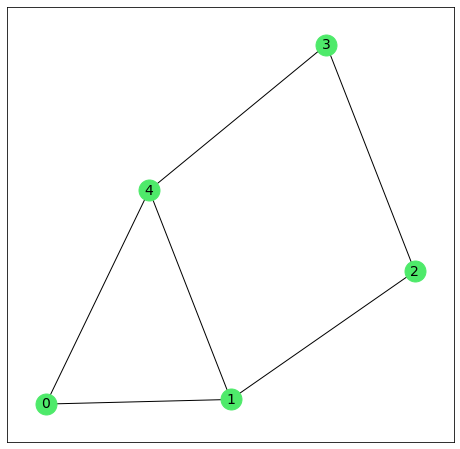

In [36]:
#This cell will create the graph (Nothing to complete here)
#Import networkx 
import networkx as nx

#Create our simple graph
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3, 4])
G.add_edge(0, 1)
G.add_edge(0, 4)
G.add_edge(1, 2)
G.add_edge(1, 4)
G.add_edge(2, 3)
G.add_edge(3, 4)

#Plot our graph
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
nodes_positions = nx.spring_layout(G, iterations=len(G.nodes())*100)
nx.draw_networkx(G, 
                 pos=nodes_positions, 
                 node_color='#4EEA6A', 
                 node_size=440, 
                 font_size=14)
plt.show()

From the graph created in the previous cell we will create the MaxCut problem.

In [41]:
from qat.vsolve.qaoa import MaxCut
problem = MaxCut(G)
print(problem)

Maximization:
 -3.0 * I^5 +
0.5 * (ZZ|[0, 1]) +
0.5 * (ZZ|[0, 4]) +
0.5 * (ZZ|[1, 2]) +
0.5 * (ZZ|[1, 4]) +
0.5 * (ZZ|[2, 3]) +
0.5 * (ZZ|[3, 4])
MaxCut:
 5 variables, 6 clauses


 To minimize our problem we are going to :
 + use ScipyMinimizePlugin from qat.plugins.
 + create a stack with ScipyMinimizePlugin and our qpu
 + create our job by using qaoa_ansatz with 3 layers
 + submit our job and print the result

In [81]:
from qat.qpus import get_default_qpu
from qat.plugins import ScipyMinimizePlugin
qpu = get_default_qpu()
stack = ScipyMinimizePlugin(method="COBYLA",
                            tol=1e-2, 
                            options={"maxiter":150}) | qpu
# We can directly call the to_job method of the Problem class to pack an Ansatz and 
# the cost observable in a single abstract Job
job = problem.qaoa_ansatz(1) # Here 1 is the number of layers of the Ansatz
result = stack.submit(job)
print("Final energy:", result.value)

Final energy: -4.109879684714644


If we wish we can print the evolution of the energy during the optimization process:

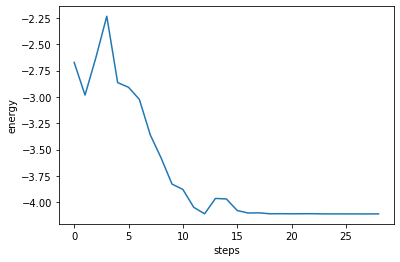

In [82]:
import matplotlib.pyplot as plt
plt.plot(eval(result.meta_data["optimization_trace"]))
plt.xlabel("steps")
plt.ylabel("energy")
plt.show()

We can now do the final run with the best parameters obtained during the optimization

Check, energy = -4.109879684714644
Most probable states are:
|00101> 0.10402551752260905
|01001> 0.0690076310755399
|01010> 0.10402551752260909
|10101> 0.10402551752260909
|10110> 0.0690076310755399
|11010> 0.10402551752260905
And as bitstrings:
00101 0.10402551752260905
0 list : [0 1 3]
1 list : [2 4]



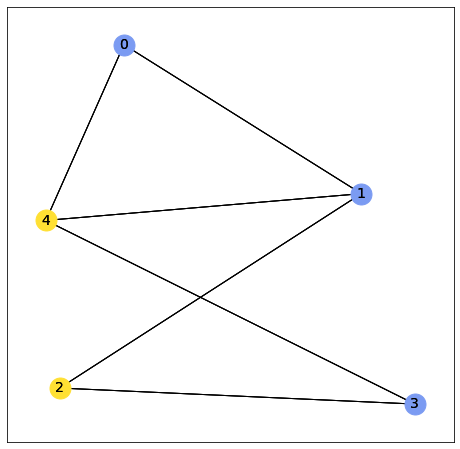

01001 0.0690076310755399
0 list : [0 2 3]
1 list : [1 4]



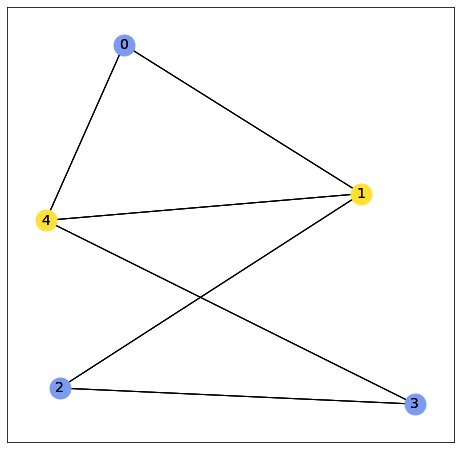

01010 0.10402551752260909
0 list : [0 2 4]
1 list : [1 3]



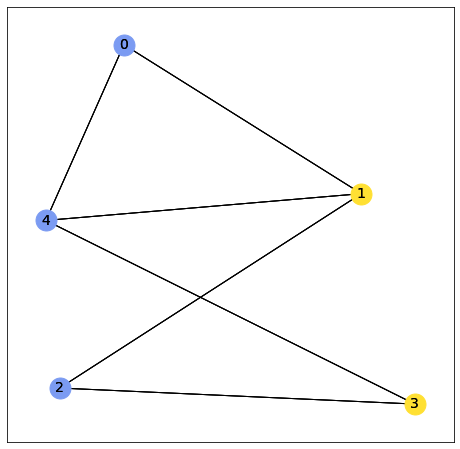

10101 0.10402551752260909
0 list : [1 3]
1 list : [0 2 4]



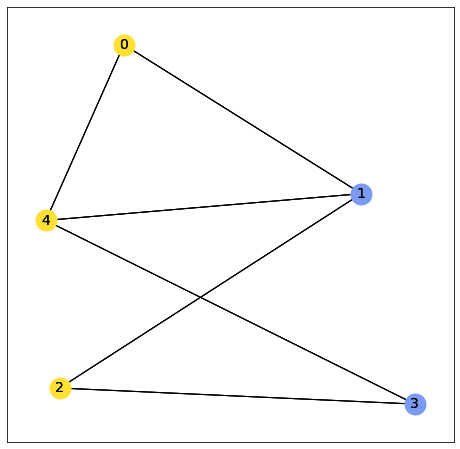

10110 0.0690076310755399
0 list : [1 4]
1 list : [0 2 3]



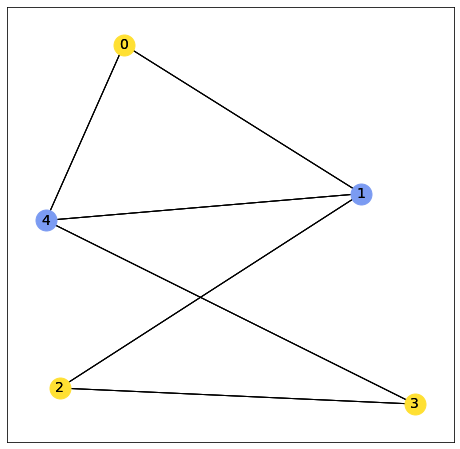

11010 0.10402551752260905
0 list : [2 4]
1 list : [0 1 3]



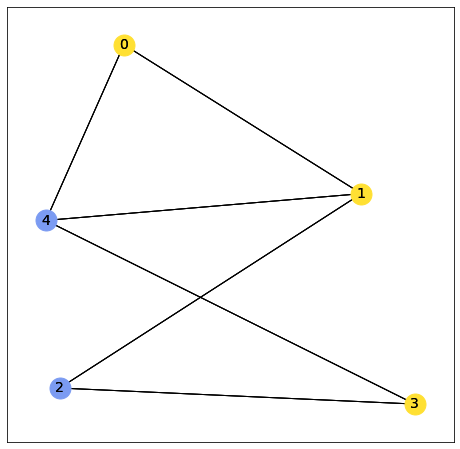

In [83]:
import numpy as np
#Retrieving the optimized parameters:
params = eval(result.meta_data['parameters'])

#Binding the variables:
sol_job = job(**{key: var for key, var in zip(job.get_variables(), params)})

#Checking that this indeeds gives the optimized energy
sol_res = qpu.submit(sol_job)
print("Check, energy =", sol_res.value)

#Rerunning in 'SAMPLE' mode to get the most probable states:
sampling_job = sol_job.circuit.to_job()
sol_res = qpu.submit(sampling_job)
print("Most probable states are:")
for sample in sol_res:
    if sample.probability > 0.05:
        print(sample.state, sample.probability)
# We can also directly cast states into bitstrings for practical use:
print("And as bitstrings:")
for sample in sol_res:
    if sample.probability > 0.05:
        print(sample.state.bitstring,  sample.probability)
        indices_bin_1 = np.where(np.array(list(sample.state.bitstring), dtype=int) == 1)[0]
        indices_bin_0 = np.where(np.array(list(sample.state.bitstring), dtype=int) == 0)[0]
        print("0 list : "+ str(indices_bin_0))
        print("1 list : " + str(indices_bin_1) + "\n")
        
        plt.figure(figsize=(8, 8))
        node_size = 440
        font_size = 14
        nx.draw_networkx(G, 
                         pos=nodes_positions, 
                         nodelist=indices_bin_1.tolist(), 
                         node_color='#FFE033', 
                         node_size=node_size, 
                         font_size=font_size)

        nx.draw_networkx(G, 
                         pos=nodes_positions, 
                         nodelist=indices_bin_0.tolist(), 
                         node_color='#7B9BF2', 
                         node_size=node_size, 
                         font_size=font_size)

        nx.draw_networkx_edges(G, pos=nodes_positions)
        plt.show()


You can if you want change the previous optimizer, namely COBYLA

Options:

        - 'Nelder-Mead' :ref:`(see here) <optimize.minimize-neldermead>`
        - 'Powell'      :ref:`(see here) <optimize.minimize-powell>`
        - 'CG'          :ref:`(see here) <optimize.minimize-cg>`
        - 'BFGS'        :ref:`(see here) <optimize.minimize-bfgs>`
        - 'Newton-CG'   :ref:`(see here) <optimize.minimize-newtoncg>`
        - 'L-BFGS-B'    :ref:`(see here) <optimize.minimize-lbfgsb>`
        - 'TNC'         :ref:`(see here) <optimize.minimize-tnc>`
        - 'COBYLA'      :ref:`(see here) <optimize.minimize-cobyla>`
        - 'SLSQP'       :ref:`(see here) <optimize.minimize-slsqp>`
        - 'trust-constr':ref:`(see here) <optimize.minimize-trustconstr>`
        - 'dogleg'      :ref:`(see here) <optimize.minimize-dogleg>`
        - 'trust-ncg'   :ref:`(see here) <optimize.minimize-trustncg>`
        - 'trust-exact' :ref:`(see here) <optimize.minimize-trustexact>`
        - 'trust-krylov' :ref:`(see here) <optimize.minimize-trustkrylov>`